In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

results_dir = Path("../results/")
params = dict()
for model in results_dir.glob("*.json"):
    # estimator = xgb.XGBClassifier()
    best_params = json.load(model.open())
    params[model.stem] = best_params

pd.DataFrame(params)[["TC-backup", "TA-backup", "CA-backup", "TCA-backup"]]

,TC-backup,TA-backup,CA-backup,TCA-backup
colsample_bytree,0.590914,0.911366,0.990764,0.897415
eta,0.212664,0.298511,0.296303,0.295458
max_depth,2.000000,4.000000,7.000000,7.000000
min_child_weight,6.000000,11.000000,8.000000,9.000000
subsample,0.944018,0.698121,0.740486,0.981343
alpha,NaN,NaN,NaN,NaN
lambda,NaN,NaN,NaN,NaN


In [2]:
from recovery_factor.validate import train_model, get_split_data
from recovery_factor.feature_importance import calculate_all_feature_importances

/home/frank/Dropbox/ROZ/code/Estimating-oil-recovery-factor-at-exploration-stage-using-XGBoost-classification-/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
importances = {}
for training_data in ("TC", "TA", "CA", "TCA"):
    importances[training_data] = calculate_all_feature_importances(
        params[f"{training_data}-backup"], training_data
    )

/home/frank/Dropbox/ROZ/code/Estimating-oil-recovery-factor-at-exploration-stage-using-XGBoost-classification-/src/recovery_factor/validate.py:188: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_independent = df_independent["Class"].replace(CLASS_DICT).astype(int)
/home/frank/Dropbox/ROZ/code/Estimating-oil-recovery-factor-at-exploration-stage-using-XGBoost-classification-/src/recovery_factor/validate.py:188: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_independent = df_independent["Class"].replace(CLASS_DICT).astype(int)
/home/frank/Dropbox/ROZ/code/Estimatin

In [4]:
feature_names_converter = {"Gor": "GOR", "Fvf": "FVF", "Api Gravity": "API Gravity"}

full_importances = pd.concat(
    [
        importances[db][data].assign(Set=data, Database=db)
        for db in importances
        for data in importances[db]
    ]
).assign(Feature=lambda x: x.Feature.str.title().replace(feature_names_converter))

In [5]:
full_importances

,Feature,Importance,Importance SE,Set,Database
8,Permeability,0.242056,0.039882,SHAP training,TC
3,Water Saturation,0.179352,0.021394,SHAP training,TC
0,API Gravity,0.125890,0.030639,SHAP training,TC
1,FVF,0.081112,0.016626,SHAP training,TC
5,Pressure,0.070720,0.011276,SHAP training,TC
...,...,...,...,...,...
3,Water Saturation,0.017023,0.001001,Permutation testing,TCA
2,GOR,0.010053,0.001281,Permutation testing,TCA
4,Temperature,0.009683,0.000969,Permutation testing,TCA
0,API Gravity,0.009211,0.000754,Permutation testing,TCA


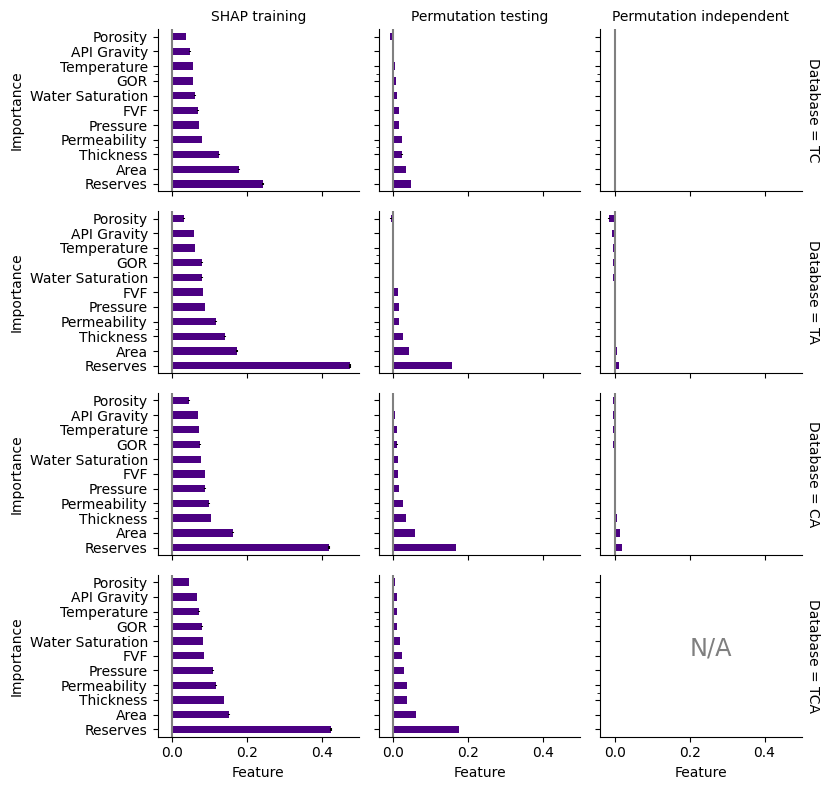

In [6]:
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="barh", ax=ax, **kwargs)
    ax.vlines(0, -0.5, 11.5, "gray")


g = sns.FacetGrid(
    full_importances, col="Set", row="Database", aspect=1.4, height=2, margin_titles=True
)
g.map_dataframe(
    errplot,
    "Feature",
    "Importance",
    "Importance SE",
    color="indigo",
)
g.set_titles(col_template="{col_name}")
g.axes[-1, -1].text(0.2, 5, "N/A", alpha=0.5, fontsize="xx-large")
g.savefig("feature_importance.png", dpi=200, bbox_inches="tight")